In [1]:
import os
import json
import numpy as np
import pandas as pd
import random
import missingno as msno
from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
total = os.listdir("data/A4C/")

In [3]:
root = ""

In [4]:
def get_train_val_dataset(MasterData):
    baseline = MasterData.loc[MasterData['Event_Name']=='Baseline'].reset_index(drop=True)
    baseline = baseline.sort_values(by=['PatientID']).reset_index(drop=True)
    after_event = MasterData.loc[MasterData['Event_Name']=='12 month'].reset_index(drop=True)
    after_event = after_event.sort_values(by=['PatientID']).reset_index(drop=True)
    
    Dataframe = baseline.copy(deep=True)
    Dataframe['LVEF_label'] = after_event['Ef'].values

    gender = []
    for i in range(len(Dataframe)):
        if(Dataframe['gender'][i]=='Male' or Dataframe['gender'][i]==1):
            gender.append(1)
        else:
            gender.append(0)
            
    Dataframe['gender'] = gender
    Dataframe['change_in_LVEF'] = Dataframe['LVEF_label'] - Dataframe['Ef']
    Dataframe['change_in_LVEF(in%)'] = ((Dataframe['LVEF_label'] - Dataframe['Ef'])/Dataframe['Ef'])*100
    Dataframe['absolute_change_in_LVEF(in%)'] = abs(((Dataframe['LVEF_label'] - Dataframe['Ef'])/Dataframe['Ef'])*100)

    class_label = []
    for i in range(len(Dataframe)):
        if(Dataframe['change_in_LVEF(in%)'][i]<-5):
            class_label.append(1)
        elif (Dataframe['change_in_LVEF(in%)'][i]>5):
            class_label.append(2)
        else:
            class_label.append(0)

    Dataframe['class'] = class_label

    print("total class 0 is" ,len(Dataframe.loc[Dataframe['class']==0]))
    print("total class 1 is" ,len(Dataframe.loc[Dataframe['class']==1]))
    print("total class 2 is" ,len(Dataframe.loc[Dataframe['class']==2]))

    print("train set should contain",len(Dataframe)*.8)
    print("test set should contain",len(Dataframe)*.20)
    return Dataframe

# Creating the Data

<b> Getting the visit data in Alberta

In [5]:
masterdata = pd.read_csv(root + 'Cleaned AH dataset ymh.csv' )
masterdata = masterdata.replace(r'^\s*.$', np.nan, regex=True)

print(len(masterdata),len(masterdata['StudyNumber'].unique()))
for i in range(len(masterdata)):
    if(masterdata['Gender'].isnull()[i]):
        masterdata.at[i,'Gender'] = masterdata['Gender'][i-1]
        masterdata.at[i,'AgeatEnrollment'] = int(masterdata['AgeatEnrollment'][i-1]) + 1
print("The null values in each column is \n " , masterdata.isna().sum())
masterdata = masterdata.sort_values(by=['StudyNumber','EventName']).reset_index(drop=True)

masterdata_all = pd.read_csv(root + 'Alberta_all_data.csv' )
masterdata_date = masterdata_all[['DateofABHClinicVisitddmmyyyy','StudyNumber', 'EventName']]
masterdata_date = masterdata_date.sort_values(by=['StudyNumber','EventName']).reset_index(drop=True)
masterdata['visit_date'] = masterdata_date['DateofABHClinicVisitddmmyyyy'].values

1111 621
The null values in each column is 
  Obs                       0
StudyNumber               0
EventName                 0
Gender                    0
AgeatEnrollment           0
Heightcm                 73
Weightkg                 73
BSAm2                    73
IVSdcm                   81
LVIDdcm                  81
LVPWdcm                  81
LVIDscm                 105
LVMI                     92
LAVI                    147
LVEDV MOD Bip (mL)      157
LVESV MOD Bip (mL)      152
LVEF                    156
MV-E (cm/sec)           618
MV-A (cm/sec)           692
EAratio                 285
MVDecT (ms)             263
PWTDI e' lateral        197
PWTDI e' septal         183
TAPSEmm                 345
TrVmax m/sec            582
RVSPTRmmHg              968
Ad                      724
LAVolume2Dml            655
ASeptalcms              692
SSeptalcms              633
ALateralcms             697
SLateralcms             891
LVOTDiametercm          656
LVOTVTIcm               619
AV

<b> Working with the mortality Data

In [6]:
#masterdata = masterdata.drop_duplicates(subset='StudyNumber', keep="first").reset_index(drop=True)
#masterdata_mortality = pd.read_csv('ECHO_mortaility.csv')
masterdata_mortality = pd.read_csv('Alberta_mortality_latest_comb.csv')
masterdata_mortality.head()
death_date = {}
for i in range(len(masterdata)):
    try:
        death_date[masterdata['StudyNumber'][i]] = masterdata_mortality.loc[masterdata_mortality['Study_ID']==masterdata['StudyNumber'][i]].iloc[0]['date_death']
    except IndexError:
        death_date[masterdata['StudyNumber'][i]] = np.nan
#sanity check
dates = []
for pid in masterdata['StudyNumber'].values:
    dates.append(death_date[pid])
masterdata['death_date'] = dates

<b> Geting the days_to_event

In [7]:
days_all = []
days = []
study_end_date = pd.to_datetime('2020-03-31')
for i in range(len(masterdata)):
    visit_date = pd.to_datetime(masterdata['visit_date'][i],dayfirst=True)
    death_date = pd.to_datetime(masterdata['death_date'][i],dayfirst=True)
    days.append((death_date - visit_date).days)
    if(masterdata.iloc[i].isnull()['death_date']):
        days_all.append((study_end_date-visit_date).days)
    else:
        days_all.append((death_date - visit_date).days)
masterdata['days_to_event'] = days
masterdata['days_to_event(all)'] = days_all
#days_to_event(all) has the final date as March 31 2017 for people who didnt die
#'DA0338' had a wrong visit date
masterdata = masterdata.loc[masterdata['days_to_event(all)']>0].reset_index(drop=True)

array([[<AxesSubplot:title={'center':'days_to_event'}>]], dtype=object)

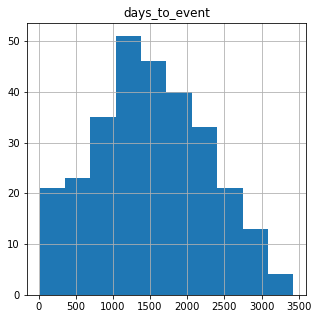

In [8]:
masterdata.loc[masterdata["days_to_event"].notnull()][["days_to_event"]].hist(figsize=(5, 5))

array([[<AxesSubplot:title={'center':'days_to_event(all)'}>]],
      dtype=object)

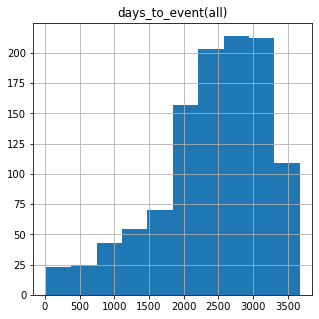

In [9]:
masterdata.loc[masterdata["days_to_event(all)"].notnull()][["days_to_event(all)"]].hist(figsize=(5, 5))

In [10]:
masterdata.to_csv("Generated_csv_files/Alberta_features.csv")

In [11]:
len(masterdata['StudyNumber'])

1110

<b> Getting the Video Information

In [12]:
extension = ".json"
null_id = []
video_id = []
heart_rate = []
BSA = []
AlbertaData = masterdata.copy(deep=True)
frames = 16
data_pid = []
for i in range(len(AlbertaData)):
    PID = AlbertaData['StudyNumber'][i][2:]
    if(AlbertaData['StudyNumber'][i][:2]=='DA' and AlbertaData['EventName'][i]=='Baseline'):
        pid = '01 ' + PID       
    elif(AlbertaData['StudyNumber'][i][:2]=='DA' and AlbertaData['EventName'][i]=='12 month'):
        pid = '01 ' + PID + ' 12M'
    elif(AlbertaData['StudyNumber'][i][:2]=='DB' and AlbertaData['EventName'][i]=='Baseline'):
        pid = '02-' + PID + '-base'
    elif(AlbertaData['StudyNumber'][i][:2]=='DB' and AlbertaData['EventName'][i]=='12 month'):
        pid = '02-' + PID + '-yr'
                 
    data_path = os.path.join(root + 'data/A4C',pid)
    data_pid.append(pid)
    try:
        files = os.listdir(data_path)
        max_prob = 0
        max_prob_id = np.nan
        json_heart_rate = np.nan
        json_BSA = np.nan
        for f in files:
            if(extension in f):
                json_path = os.path.join(data_path,f)
                with open(json_path) as f:
                    json_info = json.load(f)
                    if(max_prob<json_info['classification']['prob'] and json_info['media']['n_frames']>=frames):
                        max_prob = json_info['classification']['prob']
                        max_prob_id = json_info['id']
                        json_heart_rate = json_info['tags']['HeartRate']
                        json_BSA = json_info['study']['BSA']
        video_id.append(max_prob_id)
        heart_rate.append(json_heart_rate)
        BSA.append(json_BSA)
    except FileNotFoundError:
        video_id.append(np.nan)
        heart_rate.append(np.nan)
        null_id.append(AlbertaData['StudyNumber'][i])
        BSA.append(np.nan)

In [13]:
AlbertaData['A4C_video_path'] = video_id
AlbertaData['heart_rate'] = heart_rate
AlbertaData['fileID'] = data_pid
print(AlbertaData.isnull().sum(axis = 0))

Obs                       0
StudyNumber               0
EventName                 0
Gender                    0
AgeatEnrollment           0
Heightcm                 72
Weightkg                 72
BSAm2                    72
IVSdcm                   80
LVIDdcm                  80
LVPWdcm                  80
LVIDscm                 104
LVMI                     91
LAVI                    146
LVEDV MOD Bip (mL)      156
LVESV MOD Bip (mL)      151
LVEF                    155
MV-E (cm/sec)           617
MV-A (cm/sec)           691
EAratio                 284
MVDecT (ms)             262
PWTDI e' lateral        196
PWTDI e' septal         182
TAPSEmm                 344
TrVmax m/sec            581
RVSPTRmmHg              967
Ad                      723
LAVolume2Dml            654
ASeptalcms              691
SSeptalcms              632
ALateralcms             696
SLateralcms             890
LVOTDiametercm          655
LVOTVTIcm               618
AVPeakGradientmmHg      633
AVMeanGradientmmHg  

In [14]:
extension = ".json"
null_id = []
video_id = []
heart_rate = []
BSA = []
AlbertaData = AlbertaData.copy(deep=True)
frames = 16
for i in range(len(AlbertaData)):
    PID = AlbertaData['StudyNumber'][i][2:]
    if(AlbertaData['StudyNumber'][i][:2]=='DA' and AlbertaData['EventName'][i]=='Baseline'):
        pid = '01 ' + PID       
    elif(AlbertaData['StudyNumber'][i][:2]=='DA' and AlbertaData['EventName'][i]=='12 month'):
        pid = '01 ' + PID + ' 12M'
    elif(AlbertaData['StudyNumber'][i][:2]=='DB' and AlbertaData['EventName'][i]=='Baseline'):
        pid = '02-' + PID + '-base'
    elif(AlbertaData['StudyNumber'][i][:2]=='DB' and AlbertaData['EventName'][i]=='12 month'):
        pid = '02-' + PID + '-yr'
                 
    data_path = os.path.join(root + 'data/PLAX',pid)
    try:
        files = os.listdir(data_path)
        max_prob = 0
        max_prob_id = np.nan
        json_heart_rate = np.nan
        json_BSA = np.nan
        for f in files:
            if(extension in f):
                json_path = os.path.join(data_path,f)
                with open(json_path) as f:
                    json_info = json.load(f)
                    if(max_prob<json_info['classification']['prob'] and json_info['media']['n_frames']>=frames):
                        max_prob = json_info['classification']['prob']
                        max_prob_id = json_info['id']
                        json_heart_rate = json_info['tags']['HeartRate']
                        json_BSA = json_info['study']['BSA']
        video_id.append(max_prob_id)
        heart_rate.append(json_heart_rate)
        BSA.append(json_BSA)
    except FileNotFoundError:
        video_id.append(np.nan)
        heart_rate.append(np.nan)
        null_id.append(AlbertaData['StudyNumber'][i])
        BSA.append(np.nan)

In [15]:
AlbertaData['PLAX_video_path'] = video_id
print(AlbertaData.isnull().sum(axis = 0))

Obs                       0
StudyNumber               0
EventName                 0
Gender                    0
AgeatEnrollment           0
Heightcm                 72
Weightkg                 72
BSAm2                    72
IVSdcm                   80
LVIDdcm                  80
LVPWdcm                  80
LVIDscm                 104
LVMI                     91
LAVI                    146
LVEDV MOD Bip (mL)      156
LVESV MOD Bip (mL)      151
LVEF                    155
MV-E (cm/sec)           617
MV-A (cm/sec)           691
EAratio                 284
MVDecT (ms)             262
PWTDI e' lateral        196
PWTDI e' septal         182
TAPSEmm                 344
TrVmax m/sec            581
RVSPTRmmHg              967
Ad                      723
LAVolume2Dml            654
ASeptalcms              691
SSeptalcms              632
ALateralcms             696
SLateralcms             890
LVOTDiametercm          655
LVOTVTIcm               618
AVPeakGradientmmHg      633
AVMeanGradientmmHg  

In [16]:
len(AlbertaData.loc[AlbertaData['death_date'].notnull()]['StudyNumber'].unique())

159

In [17]:
#without removing the null values
print("The total number of Patients without a death date ", len(AlbertaData.loc[AlbertaData['death_date'].isnull()]))
print("The total number of Patients with a death date ", len(AlbertaData.loc[AlbertaData['death_date'].notnull()]))
print("The total number of alive patients within one year is ", len(AlbertaData.loc[AlbertaData['days_to_event(all)']>=365]))
print("The total number of patients with one year mortality ", len(AlbertaData.loc[(AlbertaData['death_date'].notnull()) & (AlbertaData['days_to_event(all)']<=365)]))

The total number of Patients without a death date  823
The total number of Patients with a death date  287
The total number of alive patients within one year is  1089
The total number of patients with one year mortality  21


In [18]:
AlbertaData.to_csv('Generated_csv_files/AlbertaData_Mortality_all.csv')

In [19]:
AlbertaData_PLAX = AlbertaData.dropna(axis=0, subset=['PLAX_video_path']).reset_index(drop=True)
AlbertaData_PLAX.to_csv('Generated_csv_files/AlbertaData_Mortality_PLAX.csv')
AlbertaData_PLAX = AlbertaData_PLAX.sort_values(by=['StudyNumber','EventName']).reset_index(drop=True)

In [20]:
len(AlbertaData_PLAX),len(AlbertaData_PLAX['StudyNumber'].unique())

(997, 595)

In [21]:
#without removing the null values
time_line = 365*3
print("The total number of Patients without a death date ", len(AlbertaData_PLAX.loc[AlbertaData_PLAX['death_date'].isnull()]))
print("The total number of Patients with a death date ", len(AlbertaData_PLAX.loc[AlbertaData_PLAX['death_date'].notnull()]))
print("The total number of alive patients within one year is ", len(AlbertaData_PLAX.loc[AlbertaData_PLAX['days_to_event(all)']>=time_line]))
print("The total number of patients with one year mortality ", len(AlbertaData_PLAX.loc[(AlbertaData_PLAX['death_date'].notnull()) & (AlbertaData_PLAX['days_to_event(all)']<=time_line)]))
print(AlbertaData_PLAX.isnull().sum(axis = 0))

The total number of Patients without a death date  727
The total number of Patients with a death date  270
The total number of alive patients within one year is  918
The total number of patients with one year mortality  80
Obs                      0
StudyNumber              0
EventName                0
Gender                   0
AgeatEnrollment          0
Heightcm                 8
Weightkg                 8
BSAm2                    8
IVSdcm                  13
LVIDdcm                 13
LVPWdcm                 13
LVIDscm                 35
LVMI                    21
LAVI                    72
LVEDV MOD Bip (mL)      89
LVESV MOD Bip (mL)      84
LVEF                    88
MV-E (cm/sec)          527
MV-A (cm/sec)          597
EAratio                209
MVDecT (ms)            183
PWTDI e' lateral       127
PWTDI e' septal        114
TAPSEmm                264
TrVmax m/sec           492
RVSPTRmmHg             860
Ad                     630
LAVolume2Dml           559
ASeptalcms           

In [22]:
AlbertaData_time_year = AlbertaData_PLAX.loc[((AlbertaData_PLAX['days_to_event(all)']>=time_line)) | ((AlbertaData_PLAX['death_date'].notnull()) & (AlbertaData_PLAX['days_to_event(all)']<=time_line))].reset_index(drop=True)
mortality = []
for i in range(len(AlbertaData_time_year)):
    if(AlbertaData_time_year['days_to_event(all)'][i]>=time_line):
        mortality.append(0)
    elif(AlbertaData_time_year['days_to_event'][i]<time_line):
        mortality.append(1)
    else:
        print(i)
AlbertaData_time_year['mortality'] = mortality
print("Patients with a mortality is ",len(AlbertaData_time_year.loc[AlbertaData_time_year['mortality']==1]))
print("Patients without a mortality is ",len(AlbertaData_time_year.loc[AlbertaData_time_year['mortality']==0]))
death_pid = list(AlbertaData_time_year.loc[AlbertaData_time_year['mortality']==1]['StudyNumber'].unique())
data_death_pid  = AlbertaData_time_year[AlbertaData_time_year['StudyNumber'].isin(death_pid)]
data_death_pid = data_death_pid.drop_duplicates(subset='StudyNumber', keep="first").reset_index()
AlbertaData_time_year = AlbertaData_time_year[~AlbertaData_time_year['StudyNumber'].isin(death_pid)]
frames = [AlbertaData_time_year, data_death_pid]
result = pd.concat(frames,sort=False)

Patients with a mortality is  79
Patients without a mortality is  918


In [23]:
result.to_csv('Generated_csv_files/Alberta_mortality_' + str(time_line) + '_days.csv')

In [24]:
len(result['StudyNumber'].unique())

595

In [25]:
len(result.loc[result['mortality']==1]['StudyNumber'].unique())

61

In [26]:
len(result.loc[result['mortality']==0]['StudyNumber'].unique())

534

In [27]:
len(result)

955

# Getting the Ejection Fraction Values From the Data

In [27]:
AlbertaData_Ef = AlbertaData.dropna(axis=0, subset=['LVEF','LVESV MOD Bip (mL)']).reset_index(drop=True)
AlbertaData_Ef['LVEF'] = pd.to_numeric(AlbertaData_Ef['LVEF'],errors='coerce')
AlbertaData_Ef = AlbertaData_Ef .loc[AlbertaData_Ef['LVEF']>0].reset_index(drop=True)
AlbertaData_Ef = AlbertaData_Ef.sort_values(by=['StudyNumber','EventName']).reset_index(drop=True)
masterdata = AlbertaData_Ef.copy(deep=True)
baseline = masterdata.loc[masterdata['EventName']=='Baseline'].reset_index(drop=True)
after_12_months = masterdata.loc[masterdata['EventName']=='12 month'].reset_index(drop=True)

print("checking the PID's that dont have a visit after 12 months and removing those PID's \n ")
baseline_PID = set(baseline['StudyNumber'].unique())
after_12_months_PID = set(after_12_months['StudyNumber'].unique())
print("overlapping PID's is", len(baseline_PID.union(after_12_months_PID)))
print("matching PID's is", len(baseline_PID.intersection(after_12_months_PID)))
print("PID's that dont have a study after 12 months is", len(baseline_PID - after_12_months_PID))
print("PID's that dont have a baseline is ", len(after_12_months_PID - baseline_PID))

total_pid = list(baseline_PID - after_12_months_PID) + list(after_12_months_PID - baseline_PID)
#getting the PID that have a 12 months visit
df_with_12_months_event = pd.DataFrame()
for i in range(len(masterdata)):
    if(not (masterdata['StudyNumber'][i] in list(total_pid))):
        df_with_12_months_event = df_with_12_months_event.append(masterdata[i:i+1])
        
masterdata = df_with_12_months_event.reset_index(drop=True)

    
baseline = masterdata.loc[masterdata['EventName']=='Baseline'].reset_index(drop=True)
after_12_months = masterdata.loc[masterdata['EventName']=='12 month'].reset_index(drop=True)

print("\nSanity check to see if only the Patients that have atleast 2 visits are present in the dataset \n ")
baseline_PID = set(baseline['StudyNumber'].unique())
after_12_months_PID = set(after_12_months['StudyNumber'].unique())
print("overlapping PID's is", len(baseline_PID.union(after_12_months_PID)))
print("matching PID's is", len(baseline_PID.intersection(after_12_months_PID)))
print("PID's that dont have a study after 12 months is", len(baseline_PID - after_12_months_PID))

checking the PID's that dont have a visit after 12 months and removing those PID's 
 
overlapping PID's is 596
matching PID's is 356
PID's that dont have a study after 12 months is 215
PID's that dont have a baseline is  25

Sanity check to see if only the Patients that have atleast 2 visits are present in the dataset 
 
overlapping PID's is 356
matching PID's is 356
PID's that dont have a study after 12 months is 0


In [28]:
masterdata = masterdata.rename(columns={"StudyNumber":"PatientID", "PLAX_video_path":"PLAX_video_id"})
masterdata = masterdata.drop(['Obs'],axis=1)
masterdata['IVSdcm'] = masterdata['IVSdcm']*10
masterdata['LVPWdcm'] = masterdata['LVPWdcm']*10
masterdata['LVIDdcm'] = masterdata['LVIDdcm']*10
masterdata['LVIDscm'] = masterdata['LVIDscm']*10
masterdata = masterdata.rename(columns=
                          {"IVSdcm": "Ivs", 
                           "LVPWdcm": "Lvpw",
                          "LVIDdcm":"Lvidd",
                          "LVIDscm":"Lvids",
                          "LVEDV MOD Bip (mL)":"Lvedv",
                          "LVESV MOD Bip (mL)":"Lvesv",
                          "heart_rate":"Hr",
                          "Decelerationms":"Dt",
                          "IVRTms":"Ivrt",
                          "MV-E (cm/sec)":"E",
                          "MV-A (cm/sec)":"A",
                          "PWTDI e\' lateral":"TDI_e_lateral",
                          "PWTDI e\' septal":"TDI_e_septal",
                           "Gender":"gender",
                          "AgeatEnrollment":"age",
                           "LVEF":"Ef",
                          "LAVolume2Dml":"LA_MAX_VOLUME",
                          "TrVmax m/sec":"TR_VELOCITY",
                           "EventName":"Event_Name"})
columns_to_train = ['Ivs',
                    'Lvpw',
                    'Lvidd',
                    'Lvids',
                    'Lvedv',
                    'Lvesv',
                    'Hr',
                    'Dt',
                    'Ivrt',
                    'E',
                    'A',
                    'TDI_e_lateral',
                    'TDI_e_septal',
                    'gender',
                    'age',
                    'LA_MAX_VOLUME',
                    'TR_VELOCITY',
                    'Ef']

for col in columns_to_train:
    if(col=='gender'):
        continue
    masterdata[col] = pd.to_numeric(masterdata[col],errors='coerce')

masterdata = masterdata.replace(r'^\s*$', np.nan, regex=True)
DataFrame = get_train_val_dataset(masterdata)

total class 0 is 98
total class 1 is 111
total class 2 is 147
train set should contain 284.8
test set should contain 71.2


In [29]:
DataFrame.to_csv('Generated_csv_files/Alberta_EF_within_365_days_with_' + str(time_line) + '_mortality.csv')